In [4]:
from model.compressedModel import CompressedLAVISLIPWithQueue 
from lavis.datasets.builders import load_dataset
from utils.data_utils import  get_loaders
from lavis.models import load_model_and_preprocess
from config import parser, config_dict
from config import LAVIS_BLIP_BASE_FLICKR, LAVIS_BLIP_BASE_COCO, COCO, FLICKR, DATA_PATH
import config
import os

COCO_PATH = f"{DATA_PATH}/coco/images"
FLICKR_PATH = f"{DATA_PATH}/flickr30k/flickr30k_images"
import argparse
from config import config_args, add_flags_from_config
parser = argparse.ArgumentParser()
for _, config_dict in config_args.items():
    parser = add_flags_from_config(parser, config_dict)
config, unknown = parser.parse_known_args()

In [5]:
import torch
torch.hub.set_dir(f'{DATA_PATH}/.vision_ckts')
model, vis_processors, txt_processors = load_model_and_preprocess("blip_retrieval", "coco", is_eval=False)
config.model_ckt = LAVIS_BLIP_BASE_COCO 
dataset = load_dataset("coco_retrieval", vis_path=COCO_PATH, cfg_path=None)

Using downloaded and verified file: /media/caduser/MyBook/chau/.cache/coco/annotations/coco_karpathy_train.json
Using downloaded and verified file: /media/caduser/MyBook/chau/.cache/coco/annotations/coco_karpathy_val.json
Using downloaded and verified file: /media/caduser/MyBook/chau/.cache/coco/annotations/coco_karpathy_test.json


In [6]:
from transformers import CLIPProcessor, BlipProcessor
import pandas as pd 

def coco_collate_func(sample, vis_processor, txt_processor, tokenizer):
    data = {}
    pixel_values = None 
    image = sample['image']
    text_input = sample['text_input']

    if isinstance(vis_processor, CLIPProcessor) or isinstance(vis_processor, BlipProcessor):
        pixel_values = vis_processor(images=image, return_tensors='pt')['pixel_values']
    else:
        pixel_values = vis_processor(image).unsqueeze_(0)
        if txt_processor is not None:
            text_input = txt_processor(text_input)
        else:
            text_input = text_input 
    if isinstance(tokenizer, CLIPProcessor) or isinstance(tokenizer, BlipProcessor):
        text_inputs = tokenizer(text=text_input, max_length=35, truncation=True, padding=True ,return_tensors='pt') 
    else:
        text_inputs = tokenizer(text_input, max_length=35, truncation=True, padding=True ,return_tensors='pt') 

    data['pixel_values'] = pixel_values
    data['input_ids'] = text_inputs['input_ids']
    data['attention_mask'] = text_inputs['attention_mask']

    return data

In [7]:
from torchvision import transforms
from lavis.processors.blip_processors import BlipImageEvalProcessor
from torchvision.transforms.functional import InterpolationMode


processor = BlipImageEvalProcessor()
transform_list = [
    transforms.Resize(
        (384, 384), interpolation=InterpolationMode.BICUBIC
    ),
]

# The visualization and model need different transforms
transform_vis  = transforms.Compose(transform_list)
transform_norm = transforms.Compose(transform_list + [
    transforms.ToTensor(),
    processor.normalize
])

An orange cat hiding on the wheel of a red car.


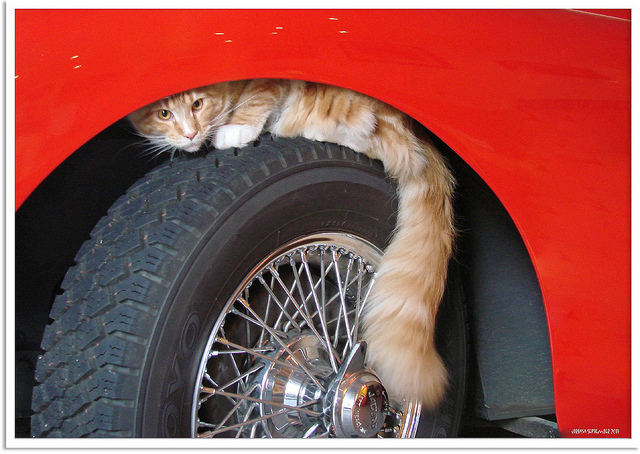

In [15]:
# index = 102
index = 300
# index = 6665 
# index = 21110 
# index = 6400 
# index = 15200 
# index = 22000 
sample = dataset['train'][index]
print(sample['text_input'])
sample['image']

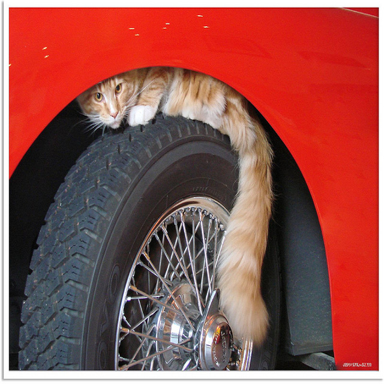

In [16]:

image = sample['image']
img_vis = transform_vis(image)
img_norm = transform_norm(image)

img_vis

In [17]:
data = coco_collate_func(sample, vis_processor=vis_processors['eval'], tokenizer=model.tokenizer, txt_processor=txt_processors['eval'])

In [18]:

config.r = 1.0
# config.compress_method = 'ToMe'
config.compress_method = 'PiToMe'
# config.compress_method = 'None'
queue_model = CompressedLAVISLIPWithQueue(config, model)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
queue_model = queue_model.to(device).eval()



trainable params: 7,143,424 || all params: 454,630,403 || trainable%: 1.5712596326295407


torch.Size([1, 576, 576])
torch.Size([1, 576])
576


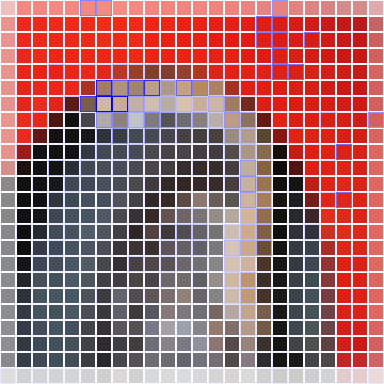

In [19]:
with torch.no_grad():
    text_embeds, _ = queue_model.get_text_features(
    input_ids=data["input_ids"].to(device), attention_mask=data["attention_mask"].to(device)
    )
    vision_embeds, hidden_states, flop ,eval_memory, sources = queue_model.get_vision_features(
        pixel_values=data["pixel_values"].to(device), return_source=True, return_attention_map=True
    )
    attns_cls = queue_model.model.get_attention_scores()[-1][..., 0,1:].mean(1).squeeze().cpu().detach().numpy()
queue_model.model.make_visualization(img=img_vis, source=sources[-1], patch_size=16, class_token=False, attention_score=attns_cls)


trainable params: 7,143,424 || all params: 454,630,403 || trainable%: 1.5712596326295407
torch.Size([1, 184, 576])
torch.Size([1, 576])
184


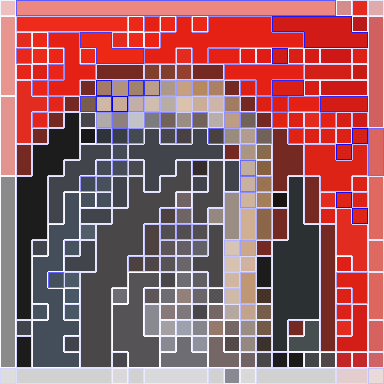

In [20]:

config.r = 0.9 
# config.compress_method = 'ToMe'
config.compress_method = 'PiToMe'
# config.compress_method = 'None'
queue_model = CompressedLAVISLIPWithQueue(config, model)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
queue_model = queue_model.to(device).eval()

with torch.no_grad():
    text_embeds, _ = queue_model.get_text_features(
    input_ids=data["input_ids"].to(device), attention_mask=data["attention_mask"].to(device)
    )
    vision_embeds, hidden_states, flop ,eval_memory, sources = queue_model.get_vision_features(
        pixel_values=data["pixel_values"].to(device), return_source=True, return_attention_map=True
    )
    attns_cls = queue_model.model.get_attention_scores()[-1][..., 0,1:].mean(1).squeeze().cpu().detach().numpy()
queue_model.model.make_visualization(img=img_vis, source=sources[-1], patch_size=16, class_token=False, attention_score=attns_cls)



trainable params: 7,143,424 || all params: 454,630,403 || trainable%: 1.5712596326295407
torch.Size([1, 184, 576])
torch.Size([1, 576])
184


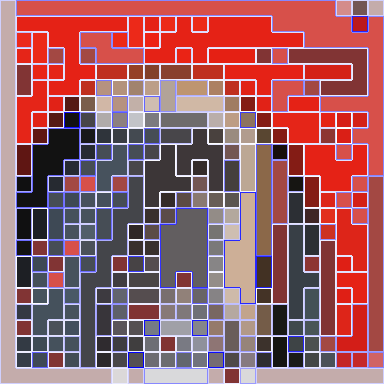

In [21]:

config.compress_method = 'ToMe'
# config.compress_method = 'PiToMe'
queue_model = CompressedLAVISLIPWithQueue(config, model)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
queue_model = queue_model.to(device).eval()

with torch.no_grad():
    text_embeds, _ = queue_model.get_text_features(
        input_ids=data["input_ids"].to(device), attention_mask=data["attention_mask"].to(device)
    )
    vision_embeds, hidden_states, flop ,eval_memory, sources = queue_model.get_vision_features(
        pixel_values=data["pixel_values"].to(device), return_source=True
    )
    attns_cls = queue_model.model.get_attention_scores()[-1][..., 0,1:].mean(1).squeeze().cpu().detach().numpy()
queue_model.model.make_visualization(img=img_vis, source=sources[-1], patch_size=16, class_token=False,attention_score=attns_cls)
